In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from tqdm.notebook import tqdm
from chainercv.evaluations import eval_detection_voc
from models import *
from config import cfg
from datasets import VOCDectectionDataset
from torchvision.ops import roi_pool, nms
from sklearn.metrics import average_precision_score
from utils import *

### OICR-pytorch

* [论文原址](http://xxx.itp.ac.cn/abs/1704.00138) 
* 训练细节：
    * 去除倒数第二个池化层，并将其后的卷积层改为dilated conv
    * vgg16中没有的层bias初始化为0，weight根据标准差0.01，均值0的高斯分布初始化
    * bs=4(即每四个backward进行一次step), 
    * 不对bias做权重衰减，且bias的梯度乘于2，优化器为SGD(momentum=0.9)
    * 不对ssw生成的roi做操作(包括去除过小的roi和去除重复的roi)，**做操作会影响模型的表现**
    * 
* 模型表现
* Model_1 在scale=(480, )情况下，去除过小roi的设置下的模型表现(Lr=1e-4, Epoch：23)：
![model1.png]('img/model1.png')
* Model_2 在scale=(480, 576, 688)情况下，去除过小roi的设置下的模型表现(Lr=1e-4, Epoch：26)：
![model2.png]('img/model2.png')

In [5]:
year='2007'
pretrained='vgg16'
if pretrained == 'alexnet':
    model = Combined_Alexnet()
elif pretrained == 'vgg16':
    model = Combined_VGG16()
model.to(cfg.DEVICE)

checkpoints = torch.load(cfg.PATH.PT_PATH + "1scale_WholeModel_2007_vgg16_40.pt")
model.load_state_dict(checkpoints['whole_model_state_dict'])


testdata = VOCDectectionDataset("~/data/", year, 'test')
test_loader = data.DataLoader(testdata, 1, shuffle=False)

log_file = cfg.PATH.LOG_PATH + f"Validate_{pretrained}" + ".txt"
write_log(log_file, f"model_name: OICR_{pretrained}")

# y_pred = []
# y_true = []

total_pred_boxes = []
total_pred_labels = []
total_pred_scores = []
total_true_boxes = []
total_true_labels = []



In [2]:
from datasets import VOCDectectionDataset
import torch.utils.data as data

testdata = VOCDectectionDataset("~/data/", '2007', 'test')
test_loader = data.DataLoader(testdata, 1, shuffle=False)

In [3]:
s = 0
i = 0
k = 200
for n_imgs, gt, n_regions, region in tqdm(test_loader, "Evaluation"):
    k -= 1
    if k == 0:
        break
    i += 1
    s += region.size()[1]
s /= i
print(s)

Evaluation:   4%|▍         | 199/4952 [00:28<11:14,  7.04it/s]

975.1608040201005


### 全部处理
s = 976
### 保留重复格子
s = 1445
### 不处理
s = 2030
### 保留小格子
s = 975

In [6]:
i_s = 0
with torch.no_grad():
    model.eval()
    n = len(cfg.DATA.SCALES)
    for n_imgs, gt, n_regions, region in tqdm(test_loader, "Evaluation"):
#         i_s += 1
        
        region = region.to(cfg.DEVICE)
        avg_scores = torch.zeros((len(region[0]), 20), dtype=torch.float32)
        scales = len(cfg.DATA.SCALES)
        k = cfg.K
        for i in range(2 * scales):
            per_img = n_imgs[i].to(cfg.DEVICE)
            per_region = n_regions[i].to(cfg.DEVICE)
            ref_scores1, ref_scores2, ref_scores3, proposal_scores = model(per_img, per_region)
            avg_scores += (ref_scores1 + ref_scores2 + ref_scores3)[:, :-1].detach().cpu() / k
        avg_scores /= 2 * scales
        
    
        gt = gt.numpy()[0]
        gt_boxex = gt[:, :4]
        gt_labels = gt[:, -1]
    
#         gt_labels_onehot = np.zeros(20)
#         for label in gt_labels:
#             gt_labels_onehot[int(label)] = 1
#         y_pred.append(avg_scores.sum(0).detach().cpu().numpy().tolist())
#         y_true.append(gt_labels_onehot.tolist())

        per_pred_boxes = []
        per_pred_scores = []
        per_pred_labels = []
        
        region = region[0].cpu()
        
        for i in range(20):
            cls_scores = avg_scores[:, i]
            cls_region = region
        
            nms_filter = nms(cls_region, cls_scores, 0.3)
            per_pred_boxes.append(cls_region[nms_filter].numpy())
            per_pred_scores.append(cls_scores[nms_filter].numpy())
            per_pred_labels.append(np.full(len(nms_filter), i, dtype=np.int32))
            
        total_pred_boxes.append(np.concatenate(per_pred_boxes, axis=0))
        total_pred_scores.append(np.concatenate(per_pred_scores, axis=0))
        total_pred_labels.append(np.concatenate(per_pred_labels, axis=0))
        total_true_boxes.append(gt_boxex)
        total_true_labels.append(gt_labels)
        
#         if i_s % 200 == 0:
#             result = eval_detection_voc(
#                 total_pred_boxes,
#                 total_pred_labels,
#                 total_pred_scores,
#                 total_true_boxes,
#                 total_true_labels,
#                 iou_thresh=0.5,
#                 use_07_metric=True,
#             )
#             print(f'Data {i_s}')
#             print(f"Avg AP: {result['ap']}")
#             print(f"Avg mAP: {result['map']}")
        
    result = eval_detection_voc(
        total_pred_boxes,
        total_pred_labels,
        total_pred_scores,
        total_true_boxes,
        total_true_labels,
        iou_thresh=0.5,
        use_07_metric=True,
    )
    print(f"Avg AP: {result['ap']}")
    print(f"Avg mAP: {result['map']}")

Evaluation: 100%|██████████| 4952/4952 [51:32<00:00,  1.60it/s]  


Avg AP: [0.45305789 0.52278321 0.31494119 0.1605501  0.11407472 0.56871555
 0.56672088 0.29751376 0.20072587 0.35148871 0.28270497 0.39960855
 0.41986282 0.55204502 0.12320259 0.15244168 0.35060675 0.31185002
 0.49883209 0.38936088]
Avg mAP: 0.35155436284670194


### vgg16 all box Epoch 40
* 1 Scale :
    * Avg AP: [0.45305789 0.52278321 0.31494119 0.1605501  0.11407472 0.56871555
 0.56672088 0.29751376 0.20072587 0.35148871 0.28270497 0.39960855
 0.41986282 0.55204502 0.12320259 0.15244168 0.35060675 0.31185002
 0.49883209 0.38936088]

**Avg mAP: 0.35155436284670194**

### vgg16 Epoch 26
Avg AP: [0.54567908 0.4996347  0.30158073 0.12829647 0.15500632 0.52944898
 0.56040761 0.23566599 0.10181557 0.32127584 0.25988094 0.28370541
 0.25501229 0.53897806 0.13112026 0.16314901 0.34275578 0.31559358
 0.44859441 0.32250795]
 
**Avg mAP: 0.3220054487259929**

In [22]:
year='2007'
pretrained='vgg16'
model = Combined_VGG16()
model.to(cfg.DEVICE)
checkpoints = torch.load(cfg.PATH.PT_PATH + "BestModel_2007_vgg16_23.pt")
model.load_state_dict(checkpoints['whole_model_state_dict'])

draw_data = VOCDectectionDataset("~/data/", '2007', 'test', debug=True)

plt.rcParams['figure.dpi'] = 200 #分辨率
d = VOCDectectionDataset("~/data/", '2007', 'trainval')

In [133]:
i_s = -1
stop = 11


testdata = VOCDectectionDataset("~/data/", year, 'test')
test_loader = data.DataLoader(testdata, 1, shuffle=False)

with torch.no_grad():
    model.eval()
    n = len(cfg.DATA.SCALES)
    for n_imgs, gt, n_regions, region in tqdm(test_loader, "Evaluation"):
        i_s += 1
        if i_s != stop:
            continue
        region = region.to(cfg.DEVICE)
        avg_scores = torch.zeros((len(region[0]), 20), dtype=torch.float32)
        scales = len(cfg.DATA.SCALES)
        k = cfg.K
        for i in range(2 * scales):
            per_img = n_imgs[i].to(cfg.DEVICE)
            per_region = n_regions[i].to(cfg.DEVICE)
            ref_scores1, ref_scores2, ref_scores3, proposal_scores = model(per_img, per_region)
            avg_scores += (ref_scores1 + ref_scores2 + ref_scores3)[:, :-1].detach().cpu() / k
        avg_scores /= 2 * scales
        
    
        gt = gt.numpy()[0]
        gt_boxex = gt[:, :4]
        gt_labels = gt[:, -1]
        break

Evaluation:   0%|          | 11/4952 [00:01<11:27,  7.18it/s]


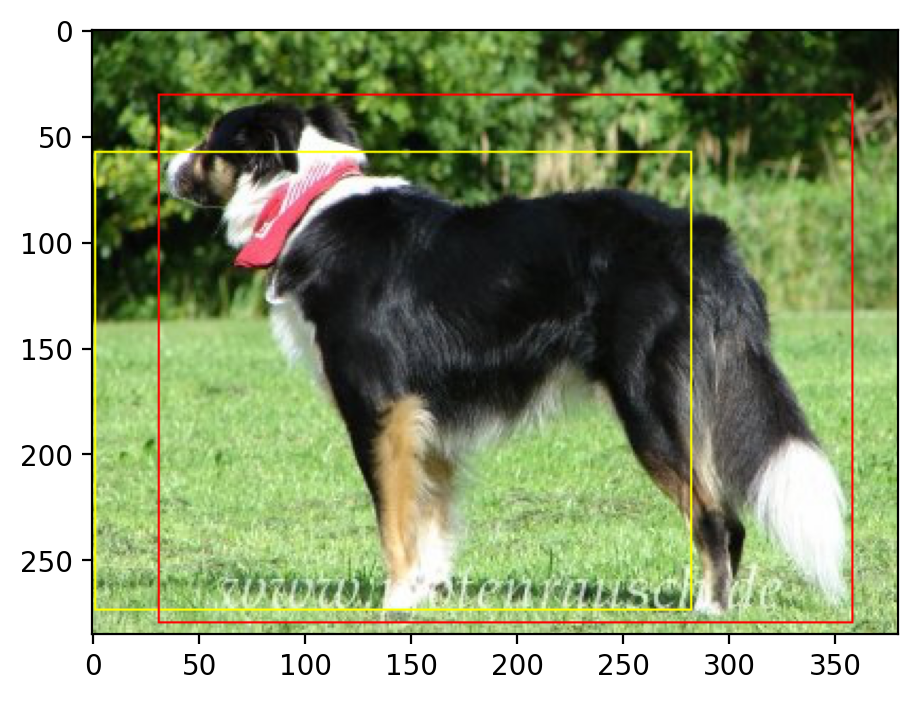

In [134]:
p, gt, region = draw_data[stop]
gt_label = gt[:, -1]
gt_box = gt[:, :4]
confident_boxes = []
last_c = -1
for c in gt_label:
    if c == last_c:
        # repeated box
        continue
    else:
        box_number = int(sum(gt_label == c))
        cls_score = avg_scores[:, int(c)]
        most_confident_ones = cls_score.topk(box_number)[1]
        most_confident_region = region[most_confident_ones].tolist()
        
        if most_confident_ones.numel() == 1:
            most_confident_region = [most_confident_region]
        confident_boxes += most_confident_region
        c = last_c
        
compare_box(p, gt_box, np.array(confident_boxes, dtype=np.float32))

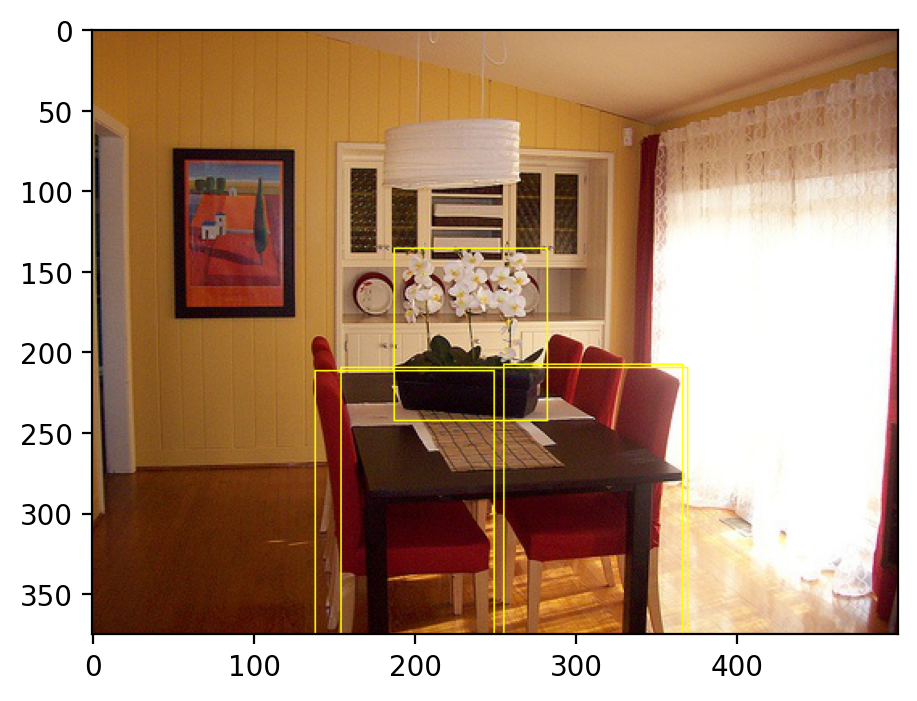

In [117]:
draw_box(p, gt_box)

In [113]:
np.array(confident_boxes)

array([[109.,  66., 470., 375.],
       [154.,  10., 267., 231.],
       [122., 172., 357., 375.],
       [161., 195., 367., 358.],
       [122., 172., 357., 375.],
       [161., 195., 367., 358.]])

In [101]:
for box in confident_boxes:
    print(box[0])

109.0
154.0
122.0
161.0
122.0
161.0


### 保留重复 1scale
* 结果
Avg AP: [0.51528531 0.4761379  0.29639384 0.072044   0.15246952 0.48327205
 0.54806089 0.2829392  0.17718942 0.35154786 0.28478669 0.25043534
 0.31737921 0.54295741 0.13165658 0.15089416 0.26156419 0.29643672
 0.43298557 0.34035406]
 
 
Avg mAP: 0.3182394966115364


#### 不处理

Avg AP: [0.54545455 0.52272727 0.33474465 0.24751534 0.11818182 0.88311688
 0.50686163 0.24294812 0.01523218 0.07204021 0.02101995 0.33887704
 0.2217743  0.35026173 0.18819881 0.30474338 0.25776565 0.01127879
 0.63135705 0.14880043]
 
Avg mAP: 0.298144989952729

#### 全处理
Avg AP: [0.54545455 0.52272727 0.32406558 0.24879857 0.09114491 0.88311688
 0.46143526 0.17292047 0.02001252 0.03666989 0.02442651 0.17917996
 0.39797186 0.34958492 0.15190994 0.34415584 0.22871213 0.00321465
 0.62443674 0.14893606]

#### 保留重复

Avg AP: [0.54545455 0.52272727 0.33500893 0.24808431 0.06734007 0.88311688
 0.51389829 0.24348116 0.01542883 0.07213071 0.02105642 0.33913359
 0.2217743  0.35064653 0.18835306 0.3095369  0.25810021 0.01158429
 0.63155684 0.14925628]
 
Avg mAP: 0.2963834718969783


#### 保留小个
Avg AP: [0.54545455 0.52272727 0.33764188 0.24848724 0.21818182 0.88311688
 0.42113206 0.17255145 0.01767394 0.03668831 0.02441599 0.18521554
 0.40143015 0.34935123 0.14482585 0.34242424 0.22873036 0.00290637
 0.61932821 0.14886676]
 
Avg mAP: 0.29255750490235266

3 scales mAP
Avg AP: [0.23025816 0.43824281 0.12920106 0.04520292 0.09731036 0.43169182
 0.50702664 0.17741842 0.00772225 0.21828119 0.34987262 0.23954935
 0.14931965 0.5172459  0.21670885 0.15837327 0.06741578 0.04310399
 0.30756206 0.33412542]

**Avg mAP: 0.23328162631466434**




3 scales 

Avg AP: [0.19290031 0.39003302 0.06290825 0.0601359  0.05282315 0.43579208
 0.47564328 0.24915475 0.00519705 0.18788292 0.22690776 0.20919535
 0.07462717 0.46995724 0.15978618 0.12134428 0.03583819 0.1011033
 0.28339706 0.34367601]
 
**Avg mAP: 0.2069151633019728**

Testset classify AP is [0.6577553332758871, 0.7647555593627995, 0.5753201462251113, 0.5499730541600497, 0.32575746457722055, 0.7164614006254473, 0.8905285321390511, 0.7407700461618217, 0.5068253598396306, 0.6058189296831907, 0.613363074549739, 0.652936466115475, 0.7706918284717089, 0.7854511641054975, 0.8980544084382357, 0.5009576055546155, 0.5726081163124578, 0.4603241822547224, 0.773465275355871, 0.6495151482356285]
Testset classify mAP is 0.6505666547722081

Epoch 52

Avg AP: [0.16170283 0.19087115 0.13452129 0.03098686 0.09150987 0.21777321
 0.14722743 0.36400218 0.00593595 0.11301976 0.09547298 0.2368045
 0.1457588  0.20088519 0.04201135 0.05161237 0.10466962 0.19736554
 0.25926547 0.04245913]
 
Avg mAP: 0.1416927737230666

Testset classify AP is [0.8663479961962571, 0.6100294414882971, 0.8819490710483422, 0.81183549295946, 0.37388020426752466, 0.7904863578834013, 0.8628470488641518, 0.866426433329239, 0.4890768184168148, 0.7283518333833807, 0.4870606016856002, 0.7921874559183721, 0.5816271064015553, 0.6123476082907197, 0.934524283766289, 0.6110137421355629, 0.7837449170924928, 0.6587259793185634, 0.8742449882777585, 0.7586305052447146]
Testset classify mAP is 0.7187668942984249



Epoch 27 
Avg AP: [0.16634298 0.16124828 0.08839409 0.04797454 0.00986132 0.18887338
 0.16362265 0.28011027 0.00690967 0.12817321 0.12970028 0.20270623
 0.11268858 0.18286619 0.04597133 0.03581916 0.02751288 0.15759736
 0.24554291 0.02903309]
 
Avg mAP: 0.1205474193844627

Testset classify AP is [0.8520569783619383, 0.5619438848860033, 0.8692711918524041, 0.8180483420479074, 0.4015153671442213, 0.755301621534193, 0.848857201564685, 0.8723894470451302, 0.45321777234666294, 0.680596567269698, 0.45391195647742855, 0.797154201703868, 0.5249316860417705, 0.5896336004502979, 0.9247360556042998, 0.6070082560226981, 0.7217856166143746, 0.6780694408420567, 0.8673328159754914, 0.7414940526319036]
Testset classify mAP is 0.7009628028208515


---------------------------------

Avg AP: [0.04996746 0.12549802 0.04110544 0.03914947 0.00034629 0.17533075
 0.10073885 0.15085075 0.00435763 0.03197182 0.002767   0.0649913
 0.00803389 0.14943469 0.03472256 0.04305286 0.01599128 0.05259232
 0.1898722  0.05069405]
 
Avg mAP: 0.06657343075574837

Testset classify AP is [0.5439304002101464, 0.3523727417489, 0.3281571936374155, 0.22592611044707314, 0.05656811429318637, 0.37828380290931113, 0.7216212807123739, 0.43806435132036814, 0.158380143505157, 0.05977517274869668, 0.08961779067309253, 0.37888591590240067, 0.05119689906636412, 0.2197437526478686, 0.7932922500104936, 0.30585290069314974, 0.20082542240744827, 0.19125449687520113, 0.584040426302915, 0.48333703837941167]

Testset classify mAP is 0.3280563102245487


alexnet 

* 40 epoch
    * 表现为 欠训练
    * 0 ~ 20 -> 1e-4
    * 20 ~ 40 -> 1e-5
    * 40 ~ 50 -> 1e-4
    * 无 gn
    * 前期使用 wrk * 10， 后15epoch恢复
    * 使用wsddn 模型预训练模型
    * 尝试继续训练
* b_loss = 0.3925406465735535
* r_loss = 0.1087707682915589
    
Avg AP: [0.14108608 0.13945433 0.07550967 0.04488512 0.0155112  0.21452098
 0.18949988 0.277173   0.01626784 0.12129407 0.04030327 0.17166375
 0.0340261  0.14652872 0.11831426 0.0943084  0.02809882 0.0808251
 0.22344707 0.10310592]
 
Avg mAP: 0.11379117919071788

Testset classify AP is [0.7446839481485761, 0.46312593526715523, 0.7229443084640751, 0.6720686580982431, 0.2711831636207078, 0.6316798087749204, 0.7808170323118933, 0.7192427670917786, 0.34050279268210454, 0.5513226437714495, 0.4250681860497294, 0.6522903973695652, 0.37552704290830424, 0.4955287776599825, 0.8895805759044773, 0.5292153332109615, 0.5930822630599464, 0.5015778652077435, 0.7728477087300736, 0.6390370031489183]

Testset classify mAP is 0.5885663105740303


* 28 epoch
    * 0 ~ 12 -> 1e-3
    * 12 ~ 28 ->1e-4
    * 无 gn
   
Avg AP: [0.00250069 0.00268959 0.00593918 0.01238983 0.00037103 0.00520011
 0.05094934 0.0025402  0.00145823 0.00060337 0.00230691 0.00568992
 0.00343817 0.00329781 0.02234189 0.00066166 0.00028807 0.00268314
 0.00682418 0.0011487 ]
 
Avg mAP: 0.006666101292653241

Testset classify AP is [0.031194349732388986, 0.0572540864953559, 0.04718262608471971, 0.027607681272222413, 0.05280227671969535, 0.05056773772898126, 0.2652140489262636, 0.04465063139115444, 0.08254710888368796, 0.020101784423735305, 0.04062878114999654, 0.07325480353317904, 0.05545111365999122, 0.0861678516354079, 0.5328506722903639, 0.05101622583523328, 0.014253184515077868, 0.03858852637022686, 0.05871458627724349, 0.04824319210879111]

Testset classify mAP is 0.08391456345168583

-----


vgg16 联合训练 oicr + GroupNorm

Avg AP: [0.09051399 0.18203187 0.08157918 0.03588963 0.00938754 0.19129429
 0.1791767  0.26907684 0.00336021 0.10906965 0.08120123 0.18342123
 0.06307971 0.15827458 0.03537233 0.0963341  0.02026587 0.13565538
 0.23144397 0.01841274]
 
Avg mAP: 0.10874205257675588

Testset classify AP is [0.861379509457694, 0.5464344555413259, 0.8003924640583021, 0.7809129075735384, 0.17323967359198622, 0.6694490297538691, 0.8282779424696932, 0.8666258007735645, 0.3152865776140701, 0.5462951295709837, 0.3261202627186228, 0.7544566528512925, 0.37742541489619386, 0.4449411781005752, 0.8810713641118815, 0.5723464026070882, 0.6089818297132764, 0.6139789231030357, 0.8293171620131501, 0.7585100285661969]

Testset classify mAP is 0.6277721354543171


vgg16 结果

Avg AP: [0.07594125 0.15202542 0.11302452 0.01443283 0.09229122 0.18310884
 0.17307478 0.19584398 0.04892519 0.03835734 0.10568615 0.10578527
 0.03219307 0.11462246 0.04233103 0.02550928 0.04346568 0.12203952
 0.18385794 0.02253245]
 
Avg mAP: 0.0942524098604717


Avg AP: [0.0380435  0.09586847 0.02967028 0.01421967 0.02488741 0.12029387
 0.12345616 0.14256291 0.00230058 0.09248682 0.09352449 0.11741401
 0.10741478 0.08556007 0.0268022  0.09133743 0.01528107 0.05298027
 0.13549627 0.03642921]
 
Avg mAP: 0.07230147397022946

Avg AP: [0.06553017 0.11218434 0.04370746 0.01982238 0.0250097  0.1920574
 0.184809   0.21933456 0.00361981 0.09866133 0.1002228  0.16470673
 0.13001323 0.14395161 0.04144958 0.09434894 0.02223967 0.06508374
 0.20686167 0.04100427]

Avg mAP: 0.09873091926663828

In [2]:
from datasets import VOCDectectionDataset
from utils import *
plt.rcParams['figure.dpi'] = 200 #分辨率
d = VOCDectectionDataset("~/data/", '2007', 'trainval')

In [3]:
p, gt_box, gt_label, regions = d[15]


origin size: w * h:(360, 500)


In [6]:
p.size

(480, 666)

In [9]:
regions

array([[  1.,   1.,  54.,  66.],
       [  1.,   1.,  45.,  70.],
       [  1.,   1.,  94.,  74.],
       ...,
       [360., 636., 413., 666.],
       [  1., 637.,  44., 666.],
       [302., 638., 345., 666.]], dtype=float32)

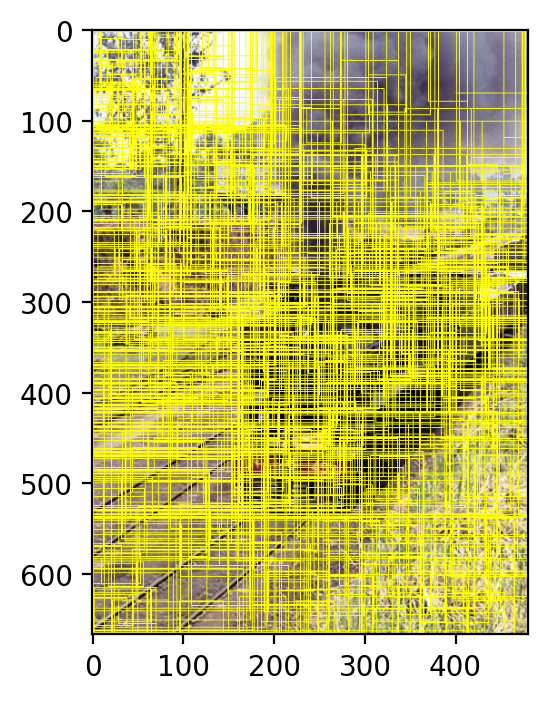

In [10]:
draw_box(p, regions)